# 02. 분류 모델 (Classification Models)

---

## 목차 / Table of Contents
1. 데이터 준비 / Data Preparation
2. 평가 지표 설명 / Evaluation Metrics
3. Logistic Regression
4. Random Forest Classifier
5. XGBoost Classifier
6. 불균형 데이터 처리 / Imbalanced Data Handling
7. 임계값 최적화 / Threshold Optimization
8. 모델 비교 / Model Comparison

In [1]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 사이킷런 / Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
from xgboost import XGBClassifier

# 불균형 처리 / Imbalanced data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# 설정 / Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("✅ 라이브러리 로드 완료 / Libraries loaded")

✅ 라이브러리 로드 완료 / Libraries loaded


---
## 1. 데이터 준비 / Data Preparation

In [2]:
# ============================================================
# 불균형 분류 데이터 생성 / Create Imbalanced Classification Data
# ============================================================

def create_imbalanced_data(n_samples=2000, n_features=10, imbalance_ratio=0.1, random_state=42):
    """
    불균형 분류 데이터 생성
    Create imbalanced classification data
    
    Args:
        n_samples: 샘플 수 / Number of samples
        n_features: 피처 수 / Number of features
        imbalance_ratio: 양성 클래스 비율 (예: 0.1 = 10%)
    """
    np.random.seed(random_state)
    
    # 클래스별 샘플 수 / Samples per class
    n_positive = int(n_samples * imbalance_ratio)
    n_negative = n_samples - n_positive
    
    # 음성 클래스 (0: 정상) / Negative class (0: Normal)
    X_neg = np.random.randn(n_negative, n_features)
    y_neg = np.zeros(n_negative)
    
    # 양성 클래스 (1: 이상) - 다른 분포 / Positive class (1: Anomaly)
    X_pos = np.random.randn(n_positive, n_features) + 1.2  # 약간 다른 평균
    y_pos = np.ones(n_positive)
    
    # 합치기 / Combine
    X = np.vstack([X_neg, X_pos])
    y = np.hstack([y_neg, y_pos])
    
    # 셔플 / Shuffle
    shuffle_idx = np.random.permutation(n_samples)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    # DataFrame 생성 / Create DataFrame
    feature_names = [f'feature_{i}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y.astype(int)
    
    return df

# 데이터 생성 (10% 양성 클래스) / Generate data (10% positive class)
df = create_imbalanced_data(n_samples=2000, imbalance_ratio=0.1)

print(f"데이터 shape: {df.shape}")
print(f"\n클래스 분포 / Class distribution:")
print(df['target'].value_counts())
print(f"\n불균형 비율: {df['target'].mean():.2%}")

데이터 shape: (2000, 11)

클래스 분포 / Class distribution:
target
0    1800
1     200
Name: count, dtype: int64

불균형 비율: 10.00%


In [3]:
# ============================================================
# 데이터 분할 / Split Data
# ============================================================

# 피처와 타겟 분리 / Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# ⚠️ 불균형 데이터는 반드시 stratify 사용!
# ⚠️ For imbalanced data, always use stratify!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 스케일링 / Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"훈련 세트: {X_train.shape}, 양성 비율: {y_train.mean():.2%}")
print(f"테스트 세트: {X_test.shape}, 양성 비율: {y_test.mean():.2%}")

훈련 세트: (1600, 10), 양성 비율: 10.00%
테스트 세트: (400, 10), 양성 비율: 10.00%


---
## 2. 평가 지표 설명 / Evaluation Metrics

### 주요 지표 / Key Metrics

| 지표 | 설명 | 언제 중요? |
|------|------|------------|
| **Accuracy** | 전체 정확도 | 균형 데이터일 때 |
| **Precision** | TP / (TP + FP) | 오탐(FP)이 비용이 클 때 |
| **Recall** | TP / (TP + FN) | 미탐(FN)이 비용이 클 때 |
| **F1 Score** | Precision과 Recall의 조화평균 | 불균형 데이터일 때 |
| **ROC-AUC** | ROC 곡선 아래 면적 | 전체적인 분류 성능 |

### 혼동 행렬 / Confusion Matrix
```
              예측 Negative    예측 Positive
실제 Negative      TN              FP (오탐)
실제 Positive      FN (미탐)        TP
```

In [4]:
# ============================================================
# 평가 함수 정의 / Define Evaluation Functions
# ============================================================

def evaluate_classification(y_true, y_pred, y_prob=None, model_name='Model'):
    """
    분류 모델 평가
    Evaluate classification model
    
    Args:
        y_true: 실제 레이블 / True labels
        y_pred: 예측 레이블 / Predicted labels
        y_prob: 예측 확률 (ROC-AUC용) / Predicted probabilities
        model_name: 모델 이름 / Model name
    """
    print(f"\n{'='*60}")
    print(f"📊 {model_name} 평가 결과 / Evaluation Results")
    print(f"{'='*60}")
    
    # 기본 지표 / Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (오탐 최소화 / Minimize FP)")
    print(f"Recall:    {recall:.4f} (미탐 최소화 / Minimize FN)")
    print(f"F1 Score:  {f1:.4f} (균형 지표 / Balanced metric)")
    
    # ROC-AUC (확률이 있을 때만)
    if y_prob is not None:
        roc_auc = roc_auc_score(y_true, y_prob)
        print(f"ROC-AUC:   {roc_auc:.4f}")
    else:
        roc_auc = None
    
    # 혼동 행렬 / Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n혼동 행렬 / Confusion Matrix:")
    print(f"TN={cm[0,0]:4d}  FP={cm[0,1]:4d}")
    print(f"FN={cm[1,0]:4d}  TP={cm[1,1]:4d}")
    
    return {
        'accuracy': accuracy, 'precision': precision, 
        'recall': recall, 'f1': f1, 'roc_auc': roc_auc
    }

def plot_confusion_matrix(y_true, y_pred, model_name='Model'):
    """
    혼동 행렬 시각화 / Visualize confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative (0)', 'Positive (1)'],
                yticklabels=['Negative (0)', 'Positive (1)'])
    plt.xlabel('Predicted / 예측')
    plt.ylabel('Actual / 실제')
    plt.title(f'{model_name} - Confusion Matrix / 혼동 행렬')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_prob, model_name='Model'):
    """
    ROC 곡선 시각화 / Visualize ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    plt.xlabel('False Positive Rate (FPR) / 오탐률')
    plt.ylabel('True Positive Rate (TPR) / 재현율')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## 3. Logistic Regression


📊 Logistic Regression 평가 결과 / Evaluation Results
Accuracy:  0.9850
Precision: 0.9250 (오탐 최소화 / Minimize FP)
Recall:    0.9250 (미탐 최소화 / Minimize FN)
F1 Score:  0.9250 (균형 지표 / Balanced metric)
ROC-AUC:   0.9974

혼동 행렬 / Confusion Matrix:
TN= 357  FP=   3
FN=   3  TP=  37


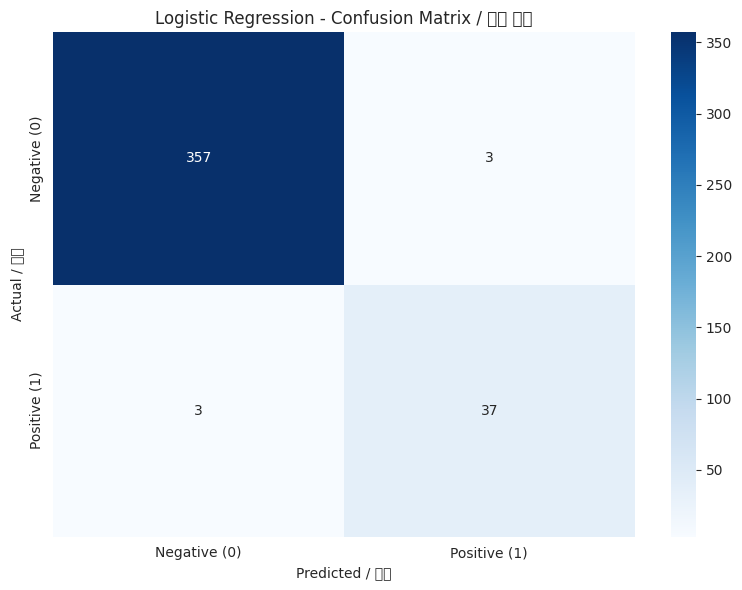

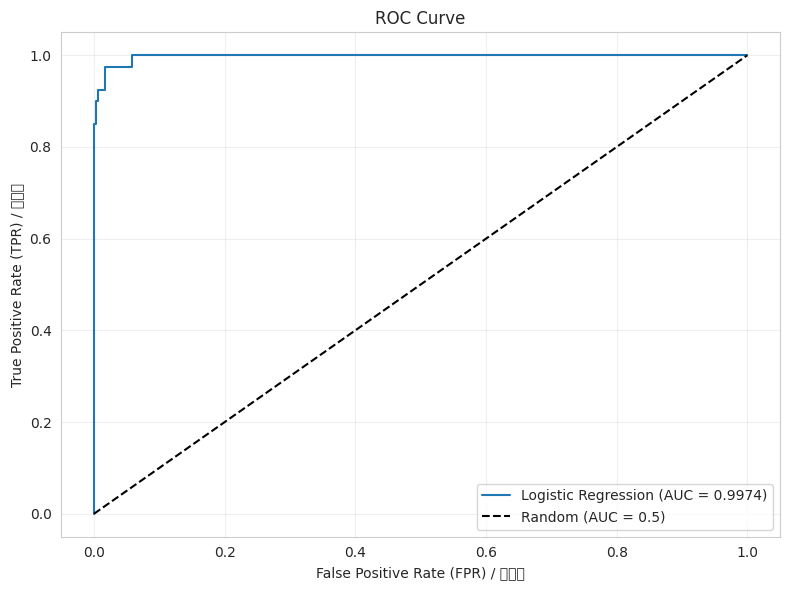

In [5]:
# ============================================================
# Logistic Regression / 로지스틱 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)

# 예측 / Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]  # 양성 클래스 확률

# 평가 / Evaluate
lr_results = evaluate_classification(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')

# 시각화 / Visualize
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')
plot_roc_curve(y_test, y_prob_lr, 'Logistic Regression')

---
## 4. Random Forest Classifier


📊 Random Forest 평가 결과 / Evaluation Results
Accuracy:  0.9750
Precision: 1.0000 (오탐 최소화 / Minimize FP)
Recall:    0.7500 (미탐 최소화 / Minimize FN)
F1 Score:  0.8571 (균형 지표 / Balanced metric)
ROC-AUC:   0.9960

혼동 행렬 / Confusion Matrix:
TN= 360  FP=   0
FN=  10  TP=  30


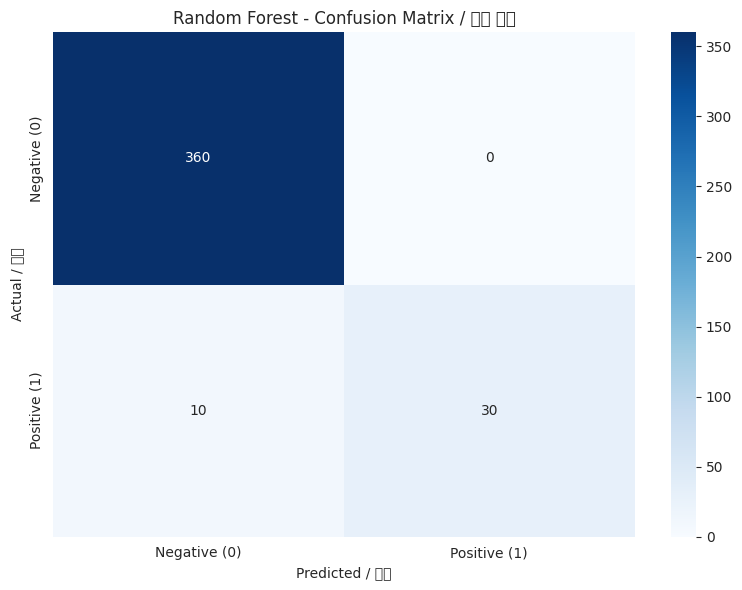

In [6]:
# ============================================================
# Random Forest Classifier / 랜덤 포레스트 분류기
# ============================================================

# 모델 생성 및 학습 / Create and train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# ⚠️ Random Forest는 스케일링 불필요
rf_model.fit(X_train, y_train)

# 예측 / Predict
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# 평가 / Evaluate
rf_results = evaluate_classification(y_test, y_pred_rf, y_prob_rf, 'Random Forest')

# 시각화 / Visualize
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

---
## 5. XGBoost Classifier


📊 XGBoost 평가 결과 / Evaluation Results
Accuracy:  0.9750
Precision: 0.9412 (오탐 최소화 / Minimize FP)
Recall:    0.8000 (미탐 최소화 / Minimize FN)
F1 Score:  0.8649 (균형 지표 / Balanced metric)
ROC-AUC:   0.9973

혼동 행렬 / Confusion Matrix:
TN= 358  FP=   2
FN=   8  TP=  32


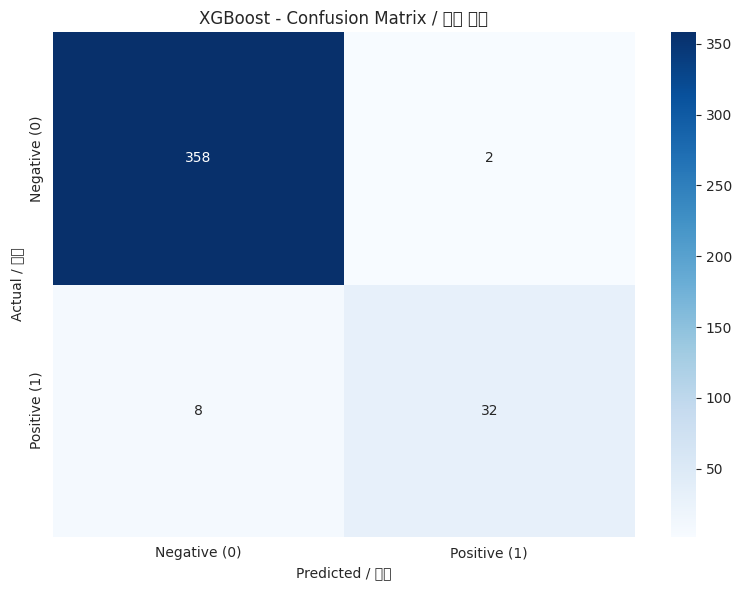

In [7]:
# ============================================================
# XGBoost Classifier / XGBoost 분류기
# ============================================================

# 모델 생성 및 학습 / Create and train model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 예측 / Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 평가 / Evaluate
xgb_results = evaluate_classification(y_test, y_pred_xgb, y_prob_xgb, 'XGBoost')

# 시각화 / Visualize
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')

---
## 6. 불균형 데이터 처리 / Imbalanced Data Handling

### 방법 1: 클래스 가중치 (class_weight)
### 방법 2: SMOTE (Synthetic Minority Over-sampling)
### 방법 3: 언더샘플링 (Undersampling)

In [8]:
# ============================================================
# 방법 1: class_weight 사용 / Method 1: Using class_weight
# ============================================================

# Random Forest with balanced class weight
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # 자동으로 가중치 계산
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)
y_pred_rf_bal = rf_balanced.predict(X_test)
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]

rf_bal_results = evaluate_classification(y_test, y_pred_rf_bal, y_prob_rf_bal, 'RF (class_weight=balanced)')


📊 RF (class_weight=balanced) 평가 결과 / Evaluation Results
Accuracy:  0.9700
Precision: 0.9667 (오탐 최소화 / Minimize FP)
Recall:    0.7250 (미탐 최소화 / Minimize FN)
F1 Score:  0.8286 (균형 지표 / Balanced metric)
ROC-AUC:   0.9953

혼동 행렬 / Confusion Matrix:
TN= 359  FP=   1
FN=  11  TP=  29


In [9]:
# ============================================================
# XGBoost: scale_pos_weight 사용 / Using scale_pos_weight
# ============================================================

# scale_pos_weight 계산 / Calculate scale_pos_weight
# = 다수 클래스 수 / 소수 클래스 수
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# XGBoost with scale_pos_weight
xgb_balanced = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # 불균형 보정
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_balanced.fit(X_train, y_train)
y_pred_xgb_bal = xgb_balanced.predict(X_test)
y_prob_xgb_bal = xgb_balanced.predict_proba(X_test)[:, 1]

xgb_bal_results = evaluate_classification(y_test, y_pred_xgb_bal, y_prob_xgb_bal, 'XGBoost (scale_pos_weight)')

scale_pos_weight: 9.00

📊 XGBoost (scale_pos_weight) 평가 결과 / Evaluation Results
Accuracy:  0.9750
Precision: 0.8947 (오탐 최소화 / Minimize FP)
Recall:    0.8500 (미탐 최소화 / Minimize FN)
F1 Score:  0.8718 (균형 지표 / Balanced metric)
ROC-AUC:   0.9951

혼동 행렬 / Confusion Matrix:
TN= 356  FP=   4
FN=   6  TP=  34


In [10]:
# ============================================================
# 방법 2: SMOTE (Synthetic Minority Over-sampling)
# ============================================================

# ⚠️ SMOTE는 훈련 데이터에만 적용! 테스트 데이터에는 절대 적용 안 함!
# ⚠️ Apply SMOTE only to training data! Never to test data!

print("SMOTE 적용 전 / Before SMOTE:")
print(f"  Class 0: {(y_train == 0).sum()}")
print(f"  Class 1: {(y_train == 1).sum()}")

# SMOTE 적용 / Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nSMOTE 적용 후 / After SMOTE:")
print(f"  Class 0: {(y_train_smote == 0).sum()}")
print(f"  Class 1: {(y_train_smote == 1).sum()}")

# SMOTE 데이터로 모델 학습 / Train model with SMOTE data
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test)
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

rf_smote_results = evaluate_classification(y_test, y_pred_rf_smote, y_prob_rf_smote, 'RF (SMOTE)')

SMOTE 적용 전 / Before SMOTE:
  Class 0: 1440
  Class 1: 160

SMOTE 적용 후 / After SMOTE:
  Class 0: 1440
  Class 1: 1440

📊 RF (SMOTE) 평가 결과 / Evaluation Results
Accuracy:  0.9825
Precision: 0.9714 (오탐 최소화 / Minimize FP)
Recall:    0.8500 (미탐 최소화 / Minimize FN)
F1 Score:  0.9067 (균형 지표 / Balanced metric)
ROC-AUC:   0.9947

혼동 행렬 / Confusion Matrix:
TN= 359  FP=   1
FN=   6  TP=  34


In [11]:
# ============================================================
# 방법 3: 언더샘플링 / Method 3: Undersampling
# ============================================================

# ⚠️ 데이터가 충분할 때만 사용 (정보 손실 발생)
# ⚠️ Use only when data is sufficient (causes information loss)

print("언더샘플링 전 / Before undersampling:")
print(f"  Class 0: {(y_train == 0).sum()}")
print(f"  Class 1: {(y_train == 1).sum()}")

# 언더샘플링 적용 / Apply undersampling
undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("\n언더샘플링 후 / After undersampling:")
print(f"  Class 0: {(y_train_under == 0).sum()}")
print(f"  Class 1: {(y_train_under == 1).sum()}")

# 언더샘플링 데이터로 모델 학습
rf_under = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_under.fit(X_train_under, y_train_under)
y_pred_rf_under = rf_under.predict(X_test)
y_prob_rf_under = rf_under.predict_proba(X_test)[:, 1]

rf_under_results = evaluate_classification(y_test, y_pred_rf_under, y_prob_rf_under, 'RF (Undersampling)')

언더샘플링 전 / Before undersampling:
  Class 0: 1440
  Class 1: 160

언더샘플링 후 / After undersampling:
  Class 0: 160
  Class 1: 160

📊 RF (Undersampling) 평가 결과 / Evaluation Results
Accuracy:  0.9575
Precision: 0.7255 (오탐 최소화 / Minimize FP)
Recall:    0.9250 (미탐 최소화 / Minimize FN)
F1 Score:  0.8132 (균형 지표 / Balanced metric)
ROC-AUC:   0.9958

혼동 행렬 / Confusion Matrix:
TN= 346  FP=  14
FN=   3  TP=  37


---
## 7. 임계값 최적화 / Threshold Optimization

기본 임계값은 0.5이지만, 불균형 데이터에서는 최적 임계값이 다를 수 있음.
Default threshold is 0.5, but optimal threshold may differ for imbalanced data.

In [12]:
# ============================================================
# 임계값에 따른 성능 변화 / Performance by Threshold
# ============================================================

def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """
    최적 임계값 찾기
    Find optimal threshold
    
    Args:
        y_true: 실제 레이블
        y_prob: 예측 확률
        metric: 최적화할 지표 ('f1', 'recall', 'precision')
    """
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    results_df = pd.DataFrame(results)
    
    # 최적 임계값 찾기 / Find optimal threshold
    best_idx = results_df[metric].idxmax()
    best_threshold = results_df.loc[best_idx, 'threshold']
    
    print(f"최적 임계값 ({metric} 기준): {best_threshold:.2f}")
    print(f"Optimal threshold (based on {metric}): {best_threshold:.2f}")
    print(f"\n해당 임계값에서의 성능:")
    print(results_df.loc[best_idx])
    
    return best_threshold, results_df

# XGBoost 모델의 최적 임계값 찾기
best_thresh, thresh_results = find_optimal_threshold(y_test, y_prob_xgb_bal, metric='f1')

최적 임계값 (f1 기준): 0.60
Optimal threshold (based on f1): 0.60

해당 임계값에서의 성능:
threshold    0.600000
precision    0.944444
recall       0.850000
f1           0.894737
Name: 10, dtype: float64


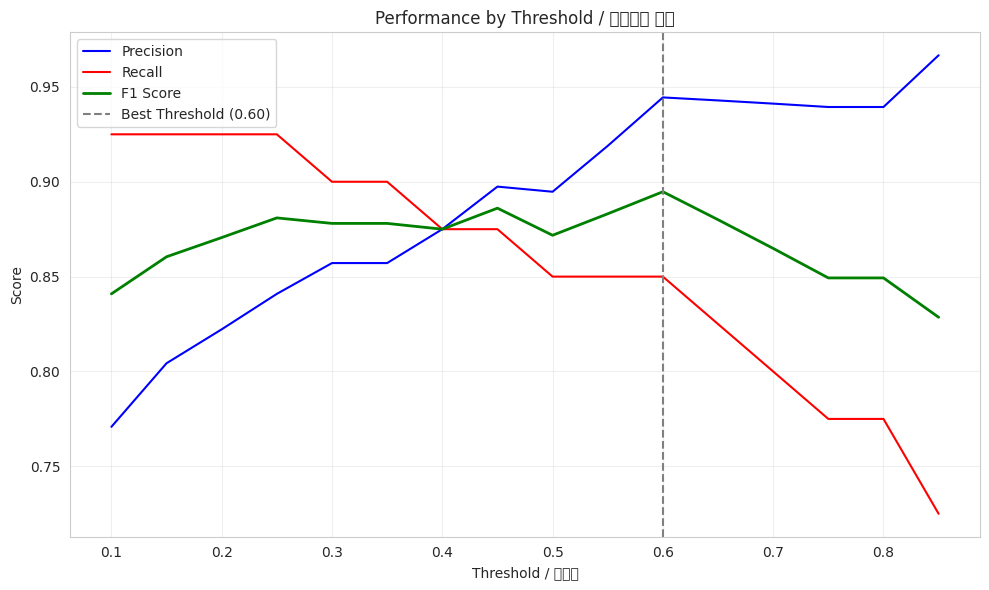

In [13]:
# ============================================================
# 임계값별 성능 시각화 / Visualize Performance by Threshold
# ============================================================

plt.figure(figsize=(10, 6))
plt.plot(thresh_results['threshold'], thresh_results['precision'], 'b-', label='Precision')
plt.plot(thresh_results['threshold'], thresh_results['recall'], 'r-', label='Recall')
plt.plot(thresh_results['threshold'], thresh_results['f1'], 'g-', label='F1 Score', linewidth=2)
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.xlabel('Threshold / 임계값')
plt.ylabel('Score')
plt.title('Performance by Threshold / 임계값별 성능')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# ============================================================
# 최적 임계값 적용 / Apply Optimal Threshold
# ============================================================

# 기본 임계값 (0.5) 결과
print("기본 임계값 (0.5) / Default threshold (0.5):")
evaluate_classification(y_test, y_pred_xgb_bal, y_prob_xgb_bal, 'XGBoost (threshold=0.5)')

# 최적 임계값 적용
print(f"\n최적 임계값 ({best_thresh:.2f}) / Optimal threshold ({best_thresh:.2f}):")
y_pred_optimal = (y_prob_xgb_bal >= best_thresh).astype(int)
evaluate_classification(y_test, y_pred_optimal, y_prob_xgb_bal, f'XGBoost (threshold={best_thresh:.2f})')

기본 임계값 (0.5) / Default threshold (0.5):

📊 XGBoost (threshold=0.5) 평가 결과 / Evaluation Results
Accuracy:  0.9750
Precision: 0.8947 (오탐 최소화 / Minimize FP)
Recall:    0.8500 (미탐 최소화 / Minimize FN)
F1 Score:  0.8718 (균형 지표 / Balanced metric)
ROC-AUC:   0.9951

혼동 행렬 / Confusion Matrix:
TN= 356  FP=   4
FN=   6  TP=  34

최적 임계값 (0.60) / Optimal threshold (0.60):

📊 XGBoost (threshold=0.60) 평가 결과 / Evaluation Results
Accuracy:  0.9800
Precision: 0.9444 (오탐 최소화 / Minimize FP)
Recall:    0.8500 (미탐 최소화 / Minimize FN)
F1 Score:  0.8947 (균형 지표 / Balanced metric)
ROC-AUC:   0.9951

혼동 행렬 / Confusion Matrix:
TN= 358  FP=   2
FN=   6  TP=  34


{'accuracy': 0.98,
 'precision': 0.9444444444444444,
 'recall': 0.85,
 'f1': 0.8947368421052632,
 'roc_auc': 0.9951388888888889}

---
## 8. 모델 비교 / Model Comparison

In [15]:
# ============================================================
# 모든 모델 비교 / Compare All Models
# ============================================================

# 결과 수집 / Collect results
all_results = pd.DataFrame([
    {'Model': 'Logistic Regression', **lr_results},
    {'Model': 'Random Forest', **rf_results},
    {'Model': 'XGBoost', **xgb_results},
    {'Model': 'RF (class_weight)', **rf_bal_results},
    {'Model': 'XGBoost (scale_pos_weight)', **xgb_bal_results},
    {'Model': 'RF (SMOTE)', **rf_smote_results},
    {'Model': 'RF (Undersampling)', **rf_under_results},
])

# F1 점수로 정렬 / Sort by F1 score
all_results = all_results.sort_values('f1', ascending=False)

print("\n" + "="*80)
print("📊 모델 비교 결과 (F1 점수 기준 정렬) / Model Comparison (sorted by F1)")
print("="*80)
print(all_results.to_string(index=False))

# 최고 모델 / Best model
best_model = all_results.iloc[0]['Model']
best_f1 = all_results.iloc[0]['f1']
print(f"\n🏆 최고 모델 / Best Model: {best_model} (F1 = {best_f1:.4f})")


📊 모델 비교 결과 (F1 점수 기준 정렬) / Model Comparison (sorted by F1)
                     Model  accuracy  precision  recall       f1  roc_auc
       Logistic Regression    0.9850   0.925000   0.925 0.925000 0.997431
                RF (SMOTE)    0.9825   0.971429   0.850 0.906667 0.994722
XGBoost (scale_pos_weight)    0.9750   0.894737   0.850 0.871795 0.995139
                   XGBoost    0.9750   0.941176   0.800 0.864865 0.997292
             Random Forest    0.9750   1.000000   0.750 0.857143 0.995972
         RF (class_weight)    0.9700   0.966667   0.725 0.828571 0.995278
        RF (Undersampling)    0.9575   0.725490   0.925 0.813187 0.995833

🏆 최고 모델 / Best Model: Logistic Regression (F1 = 0.9250)


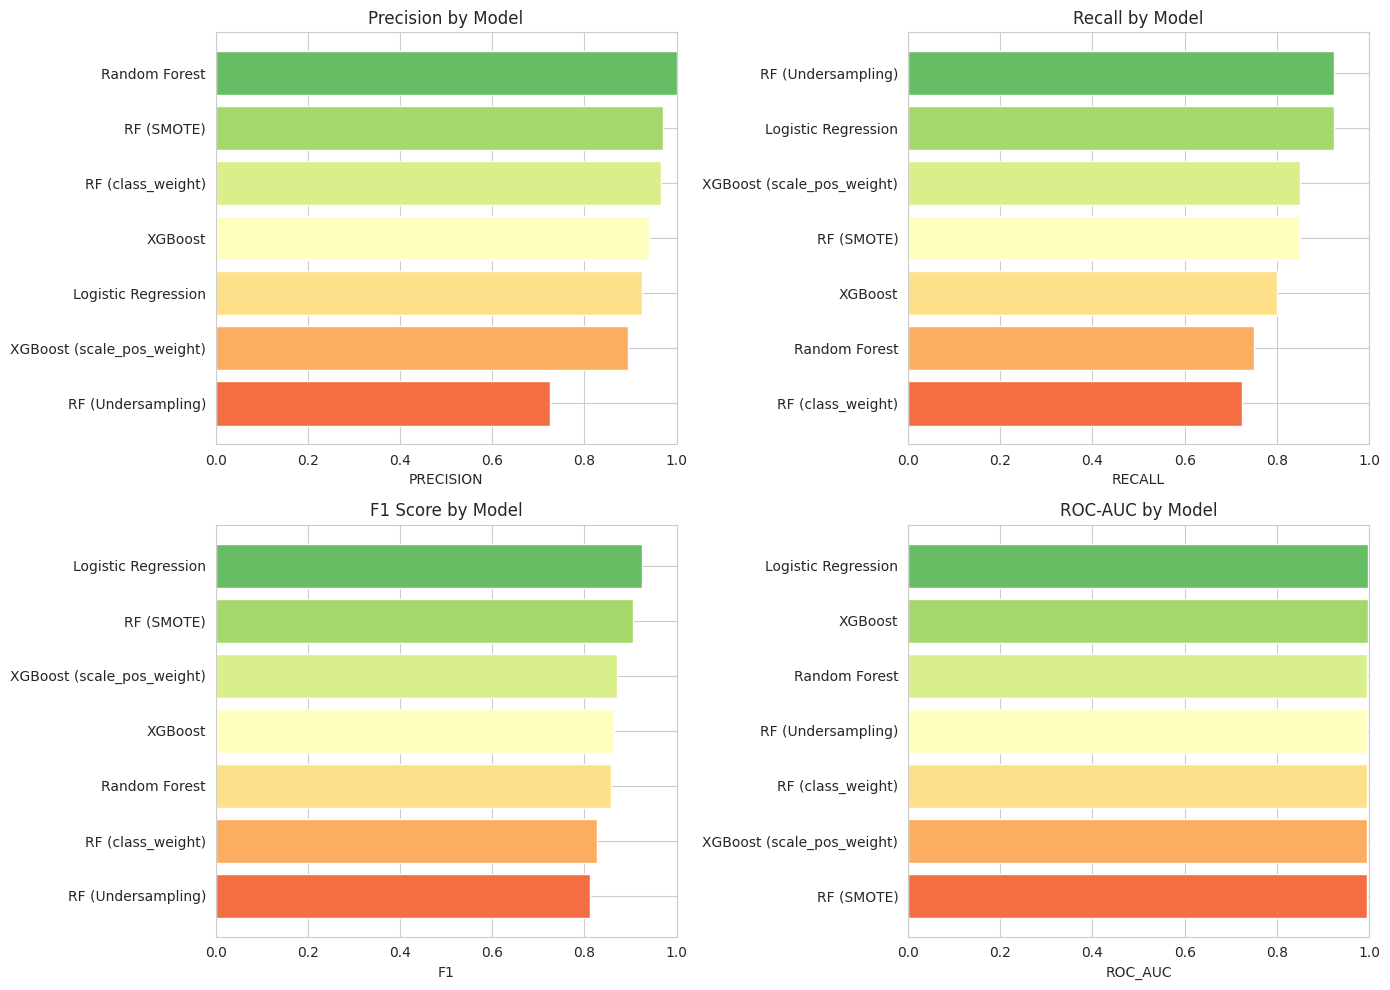

In [16]:
# ============================================================
# 모델 비교 시각화 / Visualize Model Comparison
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['precision', 'recall', 'f1', 'roc_auc']
titles = ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    data = all_results.sort_values(metric, ascending=True)
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(data)))
    ax.barh(data['Model'], data[metric], color=colors)
    ax.set_xlabel(metric.upper())
    ax.set_title(f'{title} by Model')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

---
## 요약: 분류 모델 선택 가이드 / Summary: Classification Model Selection Guide

### 불균형 데이터 처리 추천 순서 / Recommended Order for Imbalanced Data:

1. **class_weight / scale_pos_weight** - 가장 간단, 먼저 시도
2. **SMOTE** - 합성 데이터 생성, 효과적
3. **임계값 최적화** - 추가 성능 향상
4. **언더샘플링** - 데이터가 충분할 때만

### 지표 선택 가이드 / Metric Selection Guide:

| 상황 | 중요 지표 | 이유 |
|------|-----------|------|
| 불량 탐지 | Recall | 불량을 놓치면 안 됨 (FN 최소화) |
| 스팸 필터 | Precision | 정상 메일 오탐 방지 (FP 최소화) |
| 균형 필요 | F1 Score | Precision과 Recall 균형 |
| 전체 성능 | ROC-AUC | 임계값 독립적 평가 |

In [17]:
print("✅ 분류 모델 노트북 완료 / Classification models notebook complete!")
print("\n다음 노트북: 03_timeseries_arima.ipynb")
print("Next notebook: 03_timeseries_arima.ipynb")

✅ 분류 모델 노트북 완료 / Classification models notebook complete!

다음 노트북: 03_timeseries_arima.ipynb
Next notebook: 03_timeseries_arima.ipynb
